# 20211012-ipc
Evaluate IPCs for multiple variations in a tuning sweep.

In [1]:
import os
import sys
import glob
from collections import defaultdict
import attrdict
import matplotlib.pyplot as plt

In [12]:
def parse_champsim_result_file(f, max_instruction_num=None, min_instruction_interval=0):
    data = {
        'instructions': [],
        'cycles': [],
        'heartbeat_ipcs': [],
        'cumulative_ipcs': [],
        'cumulative_sim_times': [],
    }
    
    last_instruction = 0
    warmups_completed = 0 # 0 = none, 1 = CPU, 2 = CPU + prefetch
    for line in f:
        line_tokens = line.split(' ')
        
        # Only append data after the prefetch warmup completes.
        # DEBUG - Hardcoded stop condition (for now. It should stop
        # automatically, but for some reason it doesn't).
        if 'Warmup complete' in line:
            warmups_completed += 1
        
        if 'Heartbeat' in line:
            #print(line)
            instructions = int(line_tokens[line_tokens.index('instructions:') + 1])
            cycles = int(line_tokens[line_tokens.index('cycles:') + 1])
            heartbeat_ipc = float(line_tokens[line_tokens.index('heartbeat') + 2])
            cumulative_ipc = float(line_tokens[line_tokens.index('cumulative') + 2])
            cumulative_sim_time = int(line_tokens[line_tokens.index('time:') + 1]) * 3600 \
                              + int(line_tokens[line_tokens.index('time:') + 3]) * 60 \
                              + int(line_tokens[line_tokens.index('time:') + 5]) \

            # DEBUG - Temporary fix until we can figure out why
            # ChampSim runs too long.
            if max_instruction_num and instructions >= max_instruction_num: 
                warmups_completed = 0
            
            if warmups_completed >= 2 and instructions - last_instruction > min_instruction_interval:
                data['instructions'].append(instructions)
                data['cycles'].append(cycles)
                data['heartbeat_ipcs'].append(heartbeat_ipc)
                data['cumulative_ipcs'].append(cumulative_ipc)
                data['cumulative_sim_times'].append(cumulative_sim_time)
                last_instruction = instructions
    
    return attrdict.AttrDict(data)

def load_champsim_results(base, tracename, **kwargs):
    base_path = base + f'/*/*{tracename}*.txt'
    data = {}
    print('\nLoading ChampSim results from:', base_path)
    variation_paths = glob.glob(base_path)
    for path in variation_paths:
        variation_name = path.split('/')[-2]
        
        # Simplifying parameter names.
        variation_name = variation_name.replace('_embed_size', '') # page/pc_embed_size
        variation_name = variation_name.replace('_num', '') # num_experts
        variation_name = variation_name.replace('lstm_', '') # lstm_dropout/size/layers
        variation_name = variation_name.replace('learning_rate', 'lr') # learning_rate
        variation_name = variation_name.replace('dropout', 'dout') # lstm_dropout
        variation_name = variation_name.replace('batch_size', 'bsz') # batch_size
        variation_name = variation_name.replace('offset_bits', 'obits') # learning_rate
        variation_name = variation_name.replace('1e-', '1e—') # Avoid string conflicts w/ lr.
        print('Found variation:', variation_name)
        with open(path, 'r') as f:
            data[variation_name] = parse_champsim_result_file(
                f, **kwargs
            )
    return data

def load_champsim_base_results(base, tracename, **kwargs):
    base_path = base + f'/*{tracename}*.txt'
    data = {}
    print('\nLoading ChampSim base prefetcher results from:', base_path)
    variation_paths = glob.glob(base_path)
    for path in variation_paths:
        if '-bo' in os.path.basename(path):
            variation_name = 'bo'
        elif '-sisb_bo' in os.path.basename(path):
            variation_name = 'sisb-bo'
        elif '-sisb-' in os.path.basename(path):
            variation_name = 'sisb'
        elif '-no' in os.path.basename(path):
            variation_name = 'no-prefetcher'
        else:
            continue
            
        print(f'Found variation: {variation_name}')
        with open(path, 'r') as f:
            data[variation_name] = parse_champsim_result_file(
                f, **kwargs
            )
    return data
            
        
    
embeddingsizes_data = load_champsim_results('data/voyager/embeddingsizes/champsim_results', 'mcf-s0', max_instruction_num=500000000, min_instruction_interval=4900000)
lrbsz_data = load_champsim_results('data/voyager/learningrate_batchsize/champsim_results', 'mcf-s0', max_instruction_num=500000000, min_instruction_interval=4900000)
lstm_data = load_champsim_results('data/voyager/lstm/champsim_results', 'mcf-s0', max_instruction_num=500000000, min_instruction_interval=4900000)

# Base prefetchers
base_data = load_champsim_base_results('data/base/', 'mcf-s0', max_instruction_num=500000000, min_instruction_interval=4900000)
base_data


Loading ChampSim results from: data/voyager/embeddingsizes/champsim_results/*/*mcf-s0*.txt
Found variation: pc-128_page-128
Found variation: pc-128_page-256
Found variation: pc-128_page-32
Found variation: pc-128_page-64
Found variation: pc-16_page-128
Found variation: pc-16_page-256
Found variation: pc-16_page-32
Found variation: pc-256_page-128
Found variation: pc-256_page-256
Found variation: pc-256_page-32
Found variation: pc-256_page-64
Found variation: pc-32_page-128
Found variation: pc-32_page-256
Found variation: pc-32_page-32
Found variation: pc-32_page-64
Found variation: pc-64_page-128
Found variation: pc-64_page-256
Found variation: pc-64_page-32
Found variation: pc-64_page-64

Loading ChampSim results from: data/voyager/learningrate_batchsize/champsim_results/*/*mcf-s0*.txt
Found variation: lr-0.0001_bsz-128
Found variation: lr-0.0001_bsz-256
Found variation: lr-0.0001_bsz-32
Found variation: lr-0.0001_bsz-512
Found variation: lr-0.0001_bsz-64
Found variation: lr-0.001_bs

{'sisb': AttrDict({'instructions': [451000000, 456000001, 461000002, 466000003, 471000002, 476000002, 481000000, 486000000, 491000000, 496000003], 'cycles': [1450196252, 1466330797, 1482542636, 1498705415, 1514621065, 1530666149, 1546771142, 1563645006, 1579492866, 1595636845], 'heartbeat_ipcs': [0.313958, 0.324919, 0.318548, 0.324566, 0.327071, 0.320555, 0.31983, 0.292566, 0.320972, 0.293905], 'cumulative_ipcs': [0.313958, 0.310564, 0.309584, 0.309512, 0.310605, 0.3108, 0.310746, 0.308658, 0.309477, 0.309502], 'cumulative_sim_times': [2016, 2040, 2064, 2088, 2112, 2135, 2159, 2183, 2207, 2230]}),
 'sisb-bo': AttrDict({'instructions': [451000000, 456000001, 461000002, 466000002, 471000002, 476000002, 481000000, 486000000, 491000000, 496000003], 'cycles': [1450076149, 1465918840, 1481684989, 1497514295, 1513010225, 1528778796, 1544465190, 1560740575, 1576328033, 1592095702], 'heartbeat_ipcs': [0.32626, 0.331749, 0.326306, 0.327996, 0.339934, 0.329964, 0.329101, 0.301217, 0.324145, 0.304

---
# Heartbeat IPCs
- Heartbeat IPCs over test segment of the dataset.

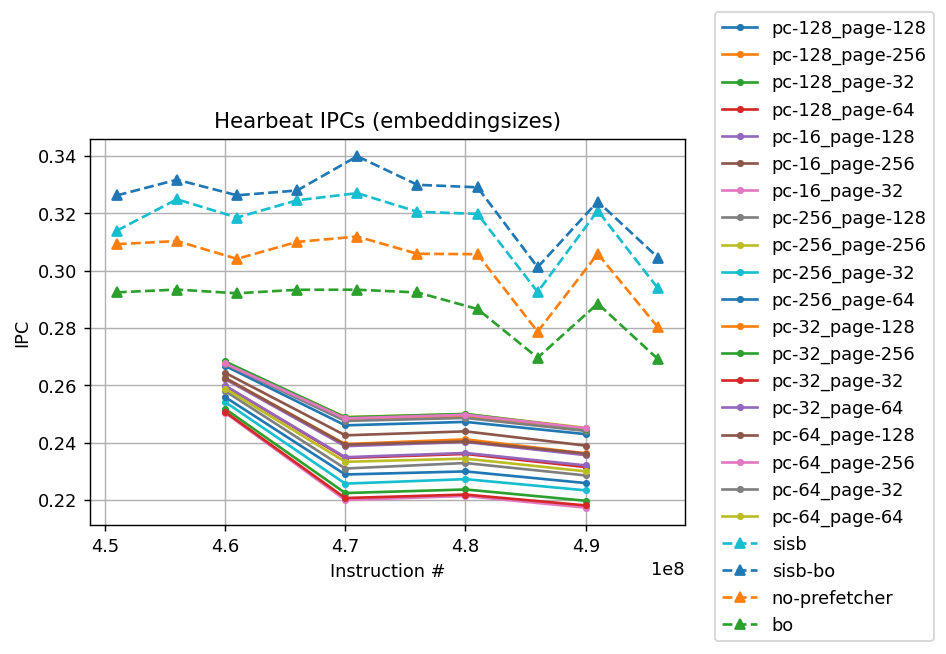

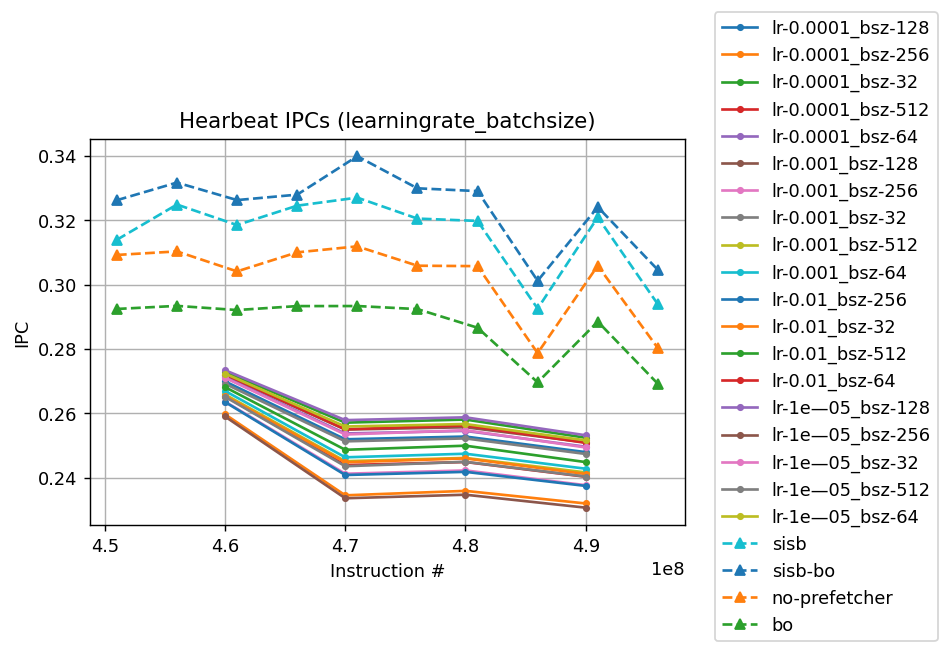

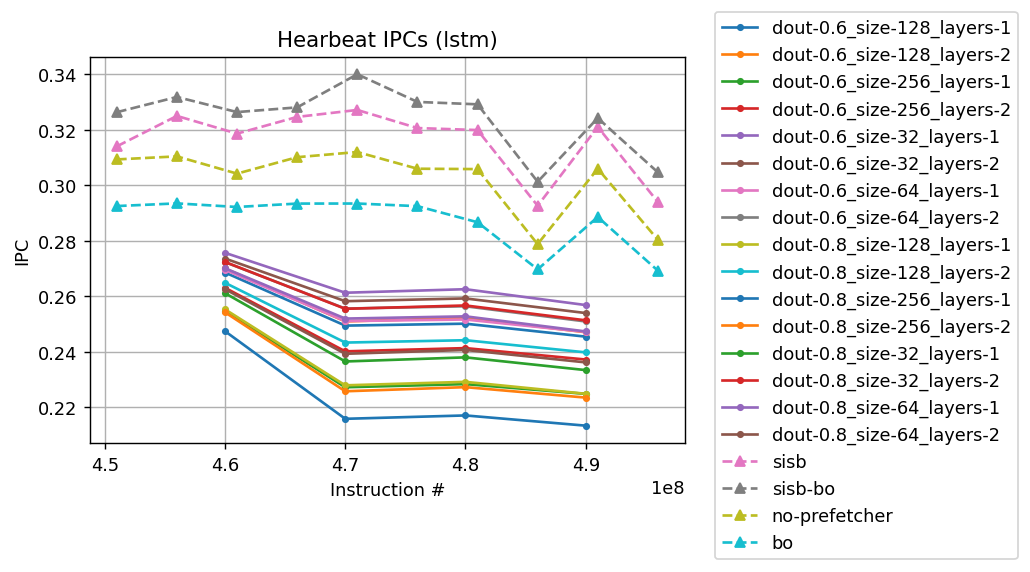

In [13]:
# TODO include baseline prefetchers.
def plot_heartbeat_ipcs(data, sweep_name='', comparisons=None):
    fig, ax = plt.subplots(dpi=128)
    for var, var_data in data.items():
        ax.plot(var_data.instructions, var_data.heartbeat_ipcs, '.-', label=var)
        
    if comparisons:
        for var, var_data in comparisons.items():
            ax.plot(var_data.instructions, var_data.heartbeat_ipcs, '^--', label=var)
        
    title = 'Hearbeat IPCs'
    if sweep_name:
        title += f' ({sweep_name})'
    ax.set_title(title)
    ax.set_xlabel('Instruction #')
    ax.set_ylabel('IPC')
    ax.legend(loc=(1.05, -0.3))
    ax.grid()
    
plot_heartbeat_ipcs(embeddingsizes_data, sweep_name='embeddingsizes', comparisons=base_data)
plot_heartbeat_ipcs(lrbsz_data, sweep_name='learningrate_batchsize', comparisons=base_data)
plot_heartbeat_ipcs(lstm_data, sweep_name='lstm', comparisons=base_data)
#plot_heartbeat_ipcs(base_data, sweep_name='base_prefetchers')

---
# Cumulative IPCs
## Cumulative IPCs
- Raw IPC values.
- Collected after the last test instruction ("final")

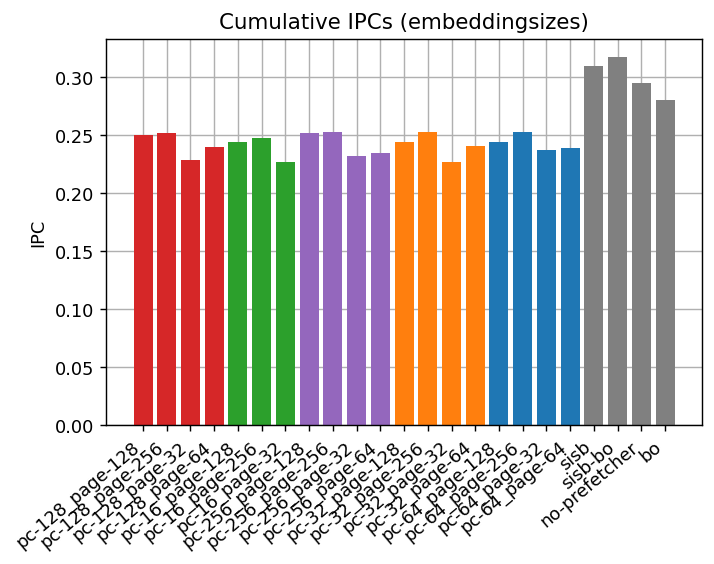

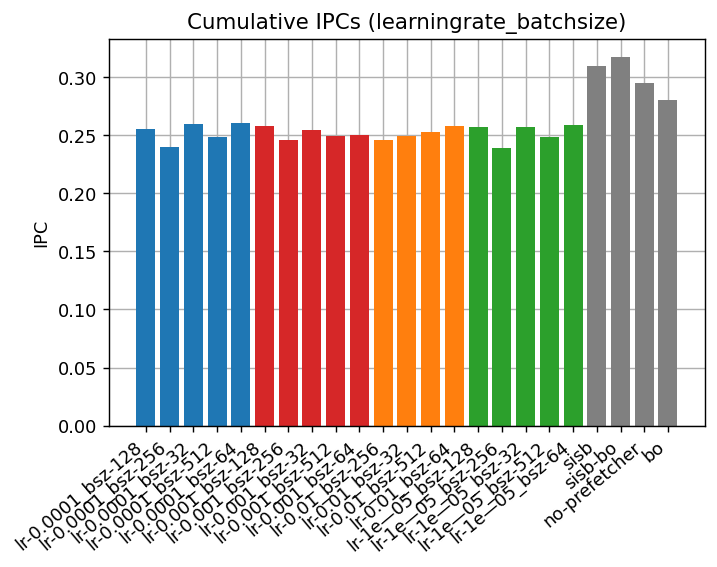

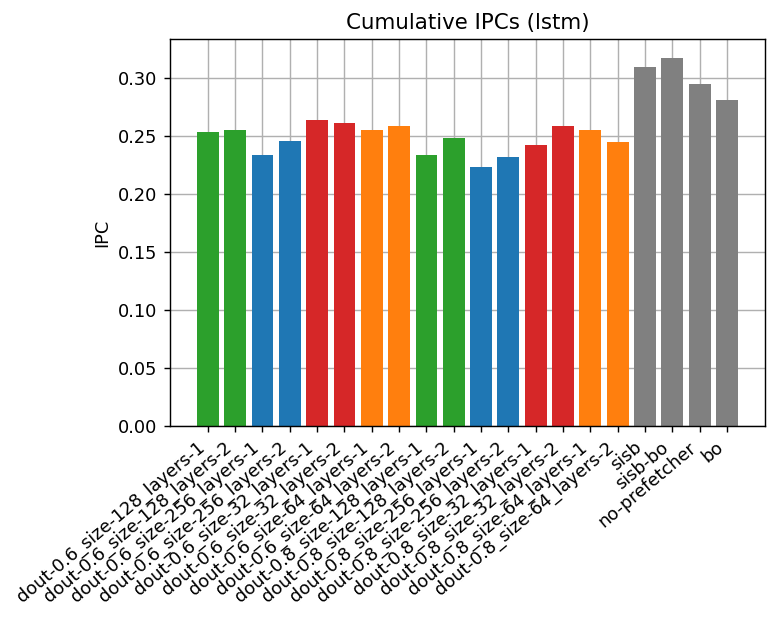

In [14]:
# TODO - rewrite for clarity + effectiveness.
# TODO - Add legend for colors, sort by color.
# - Can rewrite alongside plot_final_cumulative_ipc_speedups.
def color_of_variation(var, param_name, param_values):
    """Helper function to determine color of a variation.
    """
    tokens = var.replace('-', '_').split('_')
    param_val = tokens[tokens.index(param_name) + 1]

    for i, v in enumerate(param_values):
        if param_val == v:
            return f'C{i}'
    return 'C0' # base case
    
def plot_cumulative_ipcs(data, color_by, sweep_name='', comparisons=None):
    """Plot final cumulative IPCs, grouping bars with the
    same value for a gtiven variable with the same color.
    """    
    # Build list of possible values for the color_by variable
    potential_color_by_values = set()
    for var in data:
        tokens = var.replace('-', '_').split('_')
        potential_color_by_values.add(tokens[tokens.index(color_by) + 1])
        
    
    fig, ax = plt.subplots(dpi=128)
    ax.grid()
    ax.set_axisbelow(True) # Plot grid under bars.
    labels = []
    i = 0
    for var, var_data in data.items():
        ax.bar(
            i, var_data.cumulative_ipcs[-1], 
            color=color_of_variation(var, color_by, potential_color_by_values),
        )
        labels.append(var)
        i += 1
        
    if comparisons:
        for var, var_data in comparisons.items():
            ax.bar(
                i, var_data.cumulative_ipcs[-1],
                color='grey'
            )
            labels.append(var)
            i += 1

    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=40, ha='right')
    
    title = 'Cumulative IPCs'
    if sweep_name:
        title += f' ({sweep_name})'
    ax.set_title(title)
    ax.set_ylabel('IPC')
    
plot_cumulative_ipcs(embeddingsizes_data, 'pc', sweep_name='embeddingsizes', comparisons=base_data)
plot_cumulative_ipcs(lrbsz_data, 'lr', sweep_name='learningrate_batchsize', comparisons=base_data)
plot_cumulative_ipcs(lstm_data, 'size', sweep_name='lstm', comparisons=base_data)

## Cumulative IPC speedups
- Speedups are relative to no prefetcher.

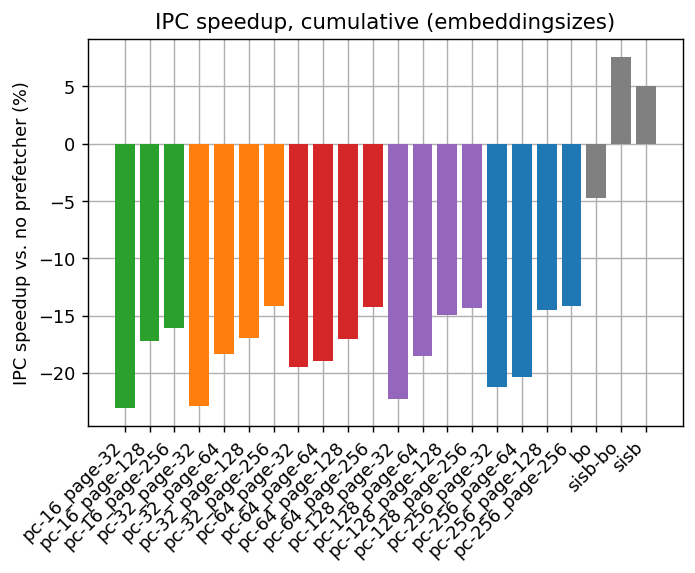

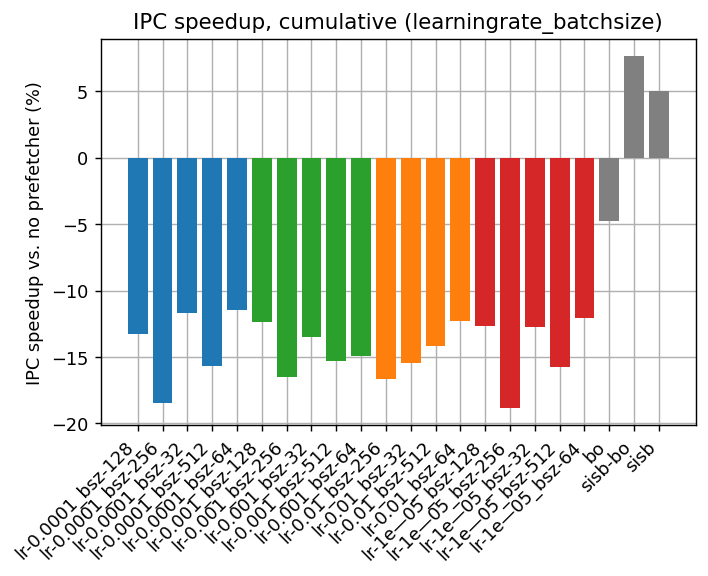

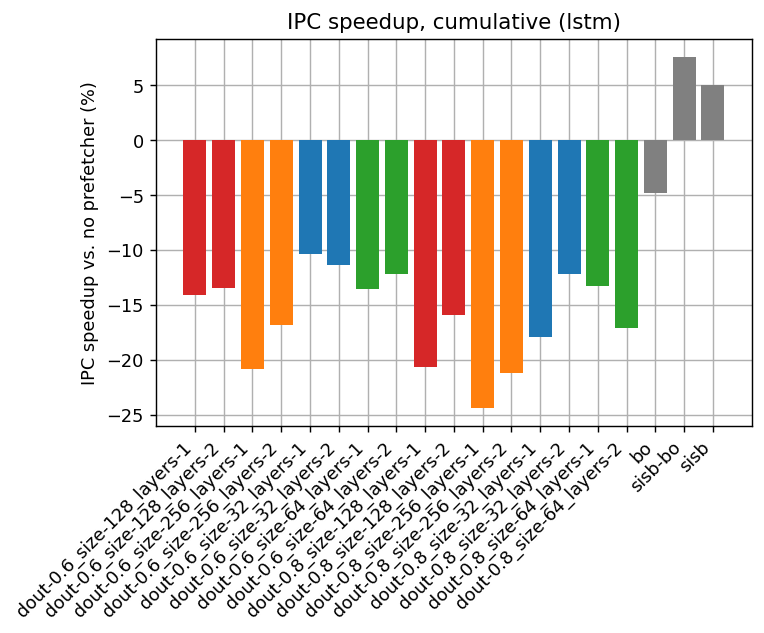

In [75]:
# TODO - rewrite for clarity + effectiveness.
# TODO - Add legend for colors, sort by color.
# - Can rewrite alongside plot_cumulative_ipcs.
def plot_cumulative_ipc_speedups(data, comparison_data, color_by, sweep_name=''):
    """Plot final cumulative IPCs, grouping bars with the
    same value for a gtiven variable with the same color.
    """    
    # Build list of possible values for the color_by variable
    potential_color_by_values = set()
    for var in data:
        tokens = var.replace('-', '_').split('_')
        potential_color_by_values.add(tokens[tokens.index(color_by) + 1])
        
    np_ipc = comparison_data['no-prefetcher'].cumulative_ipcs[-1]
        
    fig, ax = plt.subplots(dpi=128)
    ax.grid()
    ax.set_axisbelow(True) # Plot grid under bars.
    labels = []
    i = 0
    for var, var_data in data.items():
        ax.bar(
            i, (var_data.cumulative_ipcs[-1] - np_ipc)* 100./np_ipc, 
            color=color_of_variation(var, color_by, potential_color_by_values),
        )
        labels.append(var)
        i += 1
        
    for var, var_data in comparison_data.items():
        if var == 'no-prefetcher':
            continue
        ax.bar(
            i, (var_data.cumulative_ipcs[-1] - np_ipc )* 100./np_ipc,
            color='grey'
        )
        labels.append(var)
        i += 1

    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    
    title = 'IPC speedup, cumulative'
    if sweep_name:
        title += f' ({sweep_name})'
    ax.set_title(title)
    ax.set_ylabel('IPC speedup vs. no prefetcher (%)')

plot_cumulative_ipc_speedups(embeddingsizes_data, base_data, 'pc', sweep_name='embeddingsizes')
plot_cumulative_ipc_speedups(lrbsz_data, base_data, 'lr', sweep_name='learningrate_batchsize')
plot_cumulative_ipc_speedups(lstm_data, base_data, 'size', sweep_name='lstm')

---
# Sensitivity studies
## Plot sensitivity of each variable to final cumulative IPC.

In [58]:
def plot_sensitivity_ipc(data, variable, sweep_name=''):
    
    # Build list of possible values for the variable
    # Hold the other versions constant.
    var_values = set()
    for var in data:
        tokens = var.replace('-', '_').split('_')
        var_values.add(tokens[tokens.index(variable) + 1])
    var_values = sorted(var_values, key = lambda x : float(x.replace('—', '-')))
    print('Variable values:', var_values, 'for', variable)
    
    # Generate a set of lines using one of each of the potential PC values
    # (also being robust to missing sweep instances.)
    lines = set()
    for val in var_values:
        for var in data:
            tokens = var.split('_')
            #print(val, '|', var, '|', tokens, f'| removing {variable}-{val}')
            try:
                tokens.remove(f'{variable}-{val}')
                #print(val, '|', var, '|', tokens, f'| removed {variable}-{val}')
                line_name = '_'.join(tokens)
            except:
                continue
            lines.add(line_name)
    lines = sorted(lines)
    print('Lines to plot  :', lines)

    fig, ax = plt.subplots(dpi=128)
    total_X = list(range(len(var_values)))
    for line in lines:
        X = total_X.copy()
        vals = []
        matched_keys = []
        for i, k in enumerate(data.keys()):
            key_tokens = set(k.split('_'))
            line_tokens = set(line.split('_'))
            if line_tokens.issubset(key_tokens):
                vals.append(data[k].cumulative_ipcs[-1])
                matched_keys.append(k)
                
        # Iterate through expected keys to drop any missing iterations.
        for i, v in enumerate(var_values):
            v_token = f'{variable}-{v}'
            found_v = False
            for k in matched_keys:
                if v_token in k:
                    found_v = True
                    
            if not found_v:
                print(f'{v} not found for line {line}', file=sys.stderr)
                X.pop(i)

        ax.plot(X, vals, '.-', label=line)
    
    title = f'IPC sensitivity to {variable}'
    if sweep_name:
        title += f' ({sweep_name})'
    ax.set_title(title)
    ax.set_ylabel('IPC')
    ax.set_xticks(range(len(total_X)))
    ax.set_xticklabels(var_values, rotation=45, ha='right')
    ax.set_xlabel(variable)
    ax.legend(loc=(1.025, 0))
    ax.grid()

Variable values: ['16', '32', '64', '128', '256'] for pc
Lines to plot  : ['page-128', 'page-256', 'page-32', 'page-64']
Variable values: ['32', '64', '128', '256'] for page
Lines to plot  : ['pc-128', 'pc-16', 'pc-256', 'pc-32', 'pc-64']


16 not found for line page-64
64 not found for line pc-16


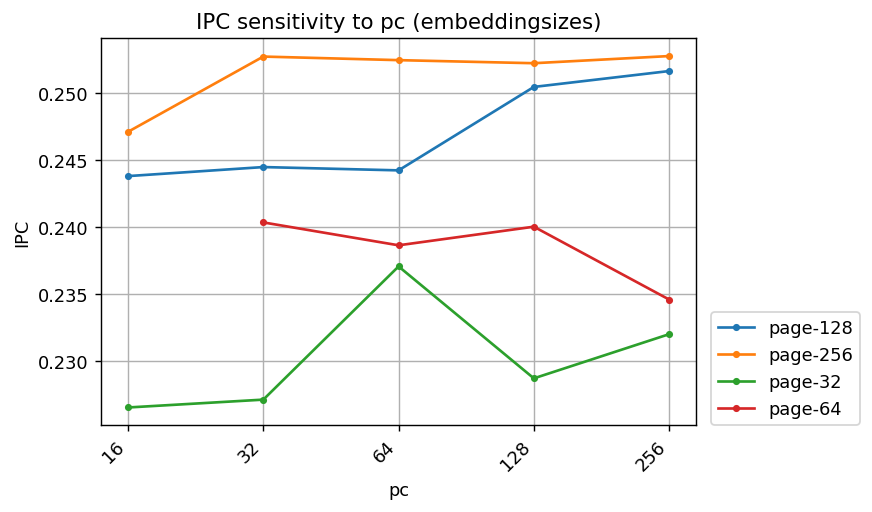

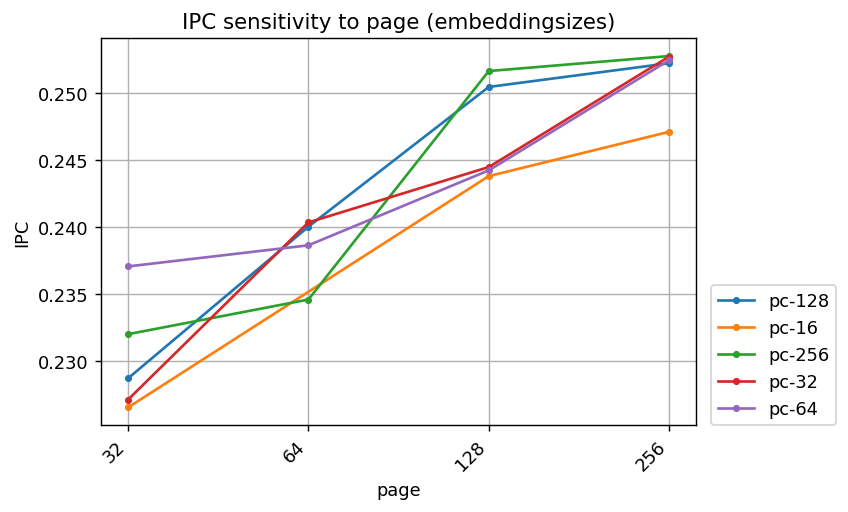

In [59]:
# Embedding sizes
plot_sensitivity_ipc(embeddingsizes_data, 'pc', sweep_name='embeddingsizes')
plot_sensitivity_ipc(embeddingsizes_data, 'page', sweep_name='embeddingsizes')

Variable values: ['0.6', '0.8'] for dout
Lines to plot  : ['size-128_layers-1', 'size-128_layers-2', 'size-256_layers-1', 'size-256_layers-2', 'size-32_layers-1', 'size-32_layers-2', 'size-64_layers-1', 'size-64_layers-2']
Variable values: ['32', '64', '128', '256'] for size
Lines to plot  : ['dout-0.6_layers-1', 'dout-0.6_layers-2', 'dout-0.8_layers-1', 'dout-0.8_layers-2']
Variable values: ['1', '2'] for layers
Lines to plot  : ['dout-0.6_size-128', 'dout-0.6_size-256', 'dout-0.6_size-32', 'dout-0.6_size-64', 'dout-0.8_size-128', 'dout-0.8_size-256', 'dout-0.8_size-32', 'dout-0.8_size-64']


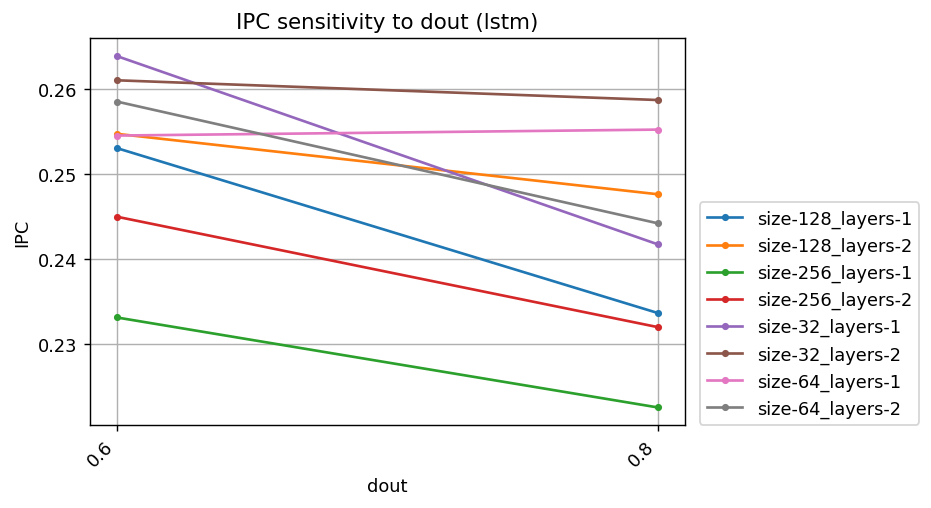

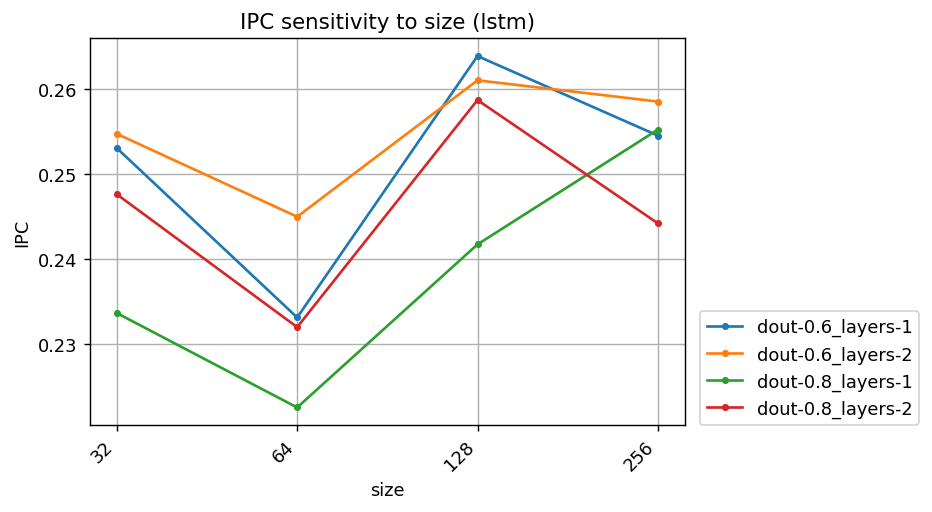

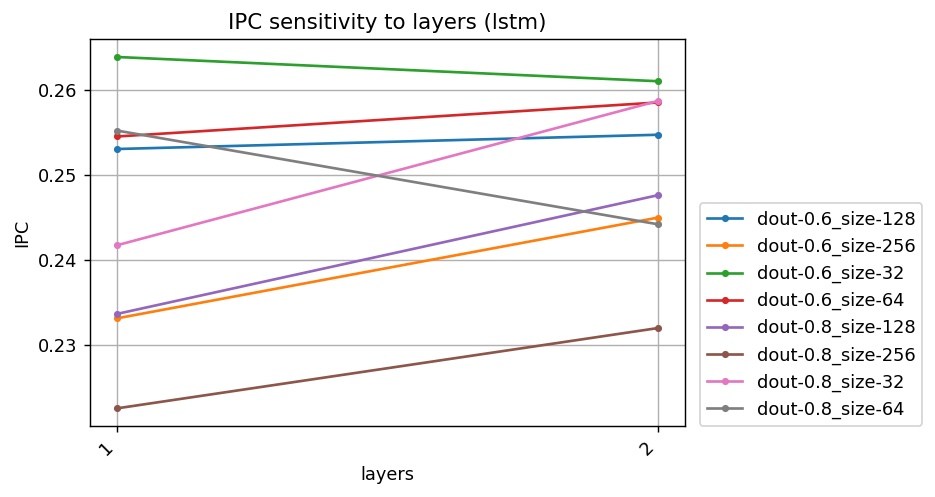

In [60]:
# LSTM
plot_sensitivity_ipc(lstm_data, 'dout', sweep_name='lstm')
plot_sensitivity_ipc(lstm_data, 'size', sweep_name='lstm')
plot_sensitivity_ipc(lstm_data, 'layers', sweep_name='lstm')

Variable values: ['1e—05', '0.0001', '0.001', '0.01'] for lr
Lines to plot  : ['bsz-128', 'bsz-256', 'bsz-32', 'bsz-512', 'bsz-64']
Variable values: ['32', '64', '128', '256', '512'] for bsz
Lines to plot  : ['lr-0.0001', 'lr-0.001', 'lr-0.01', 'lr-1e—05']


0.01 not found for line bsz-128
128 not found for line lr-0.01


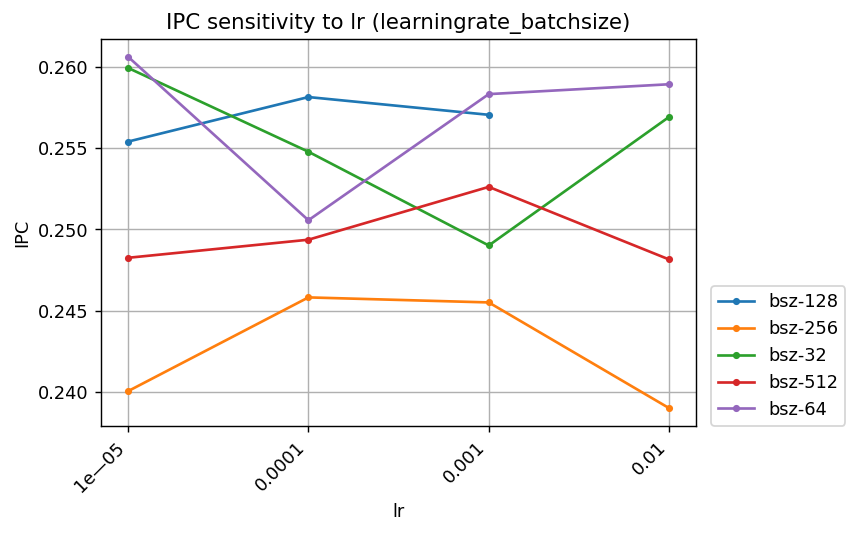

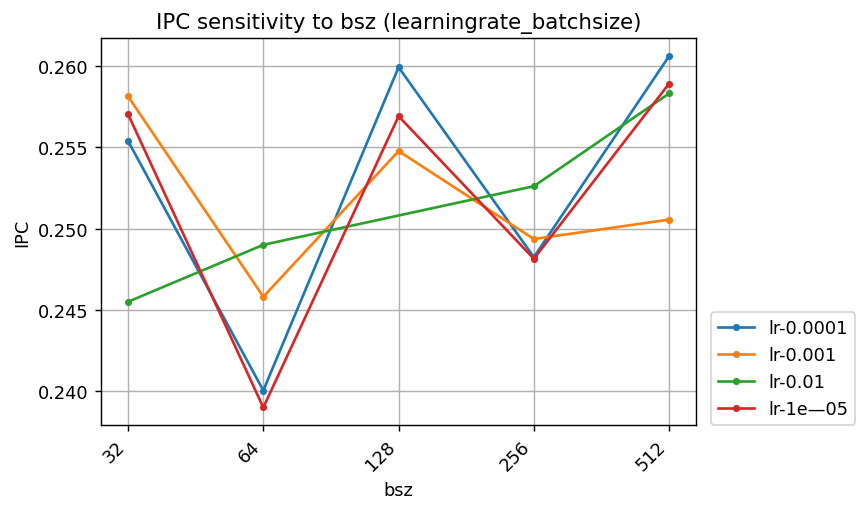

In [61]:
# Learning rate / batch size
plot_sensitivity_ipc(lrbsz_data, 'lr', sweep_name='learningrate_batchsize')
plot_sensitivity_ipc(lrbsz_data, 'bsz', sweep_name='learningrate_batchsize')